# Tracking by overlaps

This example illustrates the usage of `OverLapTrack` API by tracking segmented cells by their overlaps.

In [1]:
%pip install -q --upgrade -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


## Importing packages

`laptrack.OverLapTrack` is an extension of `laptrack.LapTrack`, which can be used for tracking labeled objects by overlaps. 

We also import `regionprops_table` from `skimage` to calculate centroids of the segmentation masks. 

In [2]:
import napari
from skimage.measure import regionprops_table
from matplotlib import pyplot as plt
from itertools import product
import numpy as np
import pandas as pd
from laptrack import OverLapTrack
from laptrack import datasets
from laptrack.data_conversion import split_merge_df_to_napari_graph

## Loading data 

Loading segmentation data and show it in the viewer.

Note: this data is generated by cropping `segmentation.npy` in https://github.com/NoneqPhysLivingMatterLab/cell_interaction_gnn .

In [3]:
labels = datasets.mouse_epidermis()

In [4]:
viewer = napari.Viewer()
viewer.add_labels(labels)

<Labels layer 'labels' at 0x14a742720>

## Tracking 

### Tracking by overlap

`OverLapTrack` API can be used instead of `LapTrack` to track integer-labeled objects in a image.
Note that `predict_overlap_dataframe` is used instead `predict` or `predict_dataframe`, which takes labeled images as the input instead of the coordinates.

For labeled regions with the label `label1` and `label2` at the frame `frame1` < `frame2`, respectively, the cost function is calculated using four quantities:

- `overlap` : the area of the intersection of the labeled regions
- `iou` : `overlap` over the area of the union of the labeled regions
- `ratio_1` : `overlap` over the area of the `label1` region
- `ratio_2` : `overlap` over the area of the `label2` region.

For each connection (tracking, gap_closing, splitting and merging), the cost is calculated by:

```
offset + overlap_coef * overlap + iou_coef * iou + ratio_1_coef * ratio_1 + ratio_2_coef * ratio_2
```

The coefficients can be specified by a tuple of 5 floats of `(offset, overlap_coef, iou_coef, ratio_1_coef, ratio_2_coef)`. For example, to use the `1-overlap` for first tracking distance and `1-ratio_2` for splitting distance, one can write as follows:

```python
OverLapTrack(
    cutoff=0.9,
    metric_coefs = (1.0, -1.0, 0.0, 0.0, 0.0),
    gap_closing_metric_coefs = (1.0, -1.0, 0.0, 0.0, 0.0),
    gap_closing_max_frame_count=1,
    splitting_cutoff=0.9,
    splitting_metric_coefs = (1.0, 0.0, 0.0, 0.0, -1.0),
)
```

In [5]:
olt = OverLapTrack(
    cutoff=0.9,
    metric_coefs=(1.0, -1.0, 0.0, 0.0, 0.0),
    gap_closing_metric_coefs=(1.0, -1.0, 0.0, 0.0, 0.0),
    gap_closing_max_frame_count=1,
    splitting_cutoff=0.9,
    splitting_metric_coefs=(1.0, 0.0, 0.0, 0.0, -1.0),
)
track_df, split_df, merge_df = olt.predict_overlap_dataframe(labels)

In [6]:
display(track_df.head())
display(split_df.head())

tree_id  track_id
frame label                   
0     1            0         0
      2            1         1
      3            2         2
      4            3         3
      5            4         4

,parent_track_id,child_track_id
0,11,134
1,11,132
2,15,135
3,15,133
4,42,138


## Showing clonal cells by the same colors

To check the result, we show the clonal cell regions by the same colors.

In [7]:
new_labels = np.zeros_like(labels)
for tree_id, grp in track_df.reset_index().groupby("tree_id"):
    for _, row in grp.iterrows():
        frame = int(row["frame"])
        label = int(row["label"])
        new_labels[frame][labels[frame] == label] = tree_id + 1

In [8]:
viewer.layers["labels"].visible = False
viewer.add_labels(new_labels)

<Labels layer 'new_labels' at 0x14c73ae70>

2025-07-25 11:51:53.715 python[67384:878539] IMKClient Stall detected, *please Report* your user scenario attaching a spindump (or sysdiagnose) that captures the problem - (imkxpc_bundleIdentifierWithReply:) block performed very slowly (1.59 secs).


## Adding tracks connecting the centroids

### Create coordinate dataframe

Make the coordinate dataframe including the centroids to show the track data in the viewer.

In [9]:
dfs = []
for frame in range(len(labels)):
    df = pd.DataFrame(
        regionprops_table(labels[frame], properties=["label", "centroid"])
    )
    df["frame"] = frame
    dfs.append(df)
coordinate_df = pd.concat(dfs).set_index(["frame", "label"])
track_df2 = pd.merge(
    track_df, coordinate_df, right_index=True, left_index=True
).reset_index()
display(track_df2.head())

,frame,label,tree_id,track_id,centroid-0,centroid-1
0,0,1,0,0,148.526627,2.278107
1,0,2,1,1,108.118367,3.742857
2,0,3,2,2,62.957143,2.964286
3,0,4,3,3,249.611111,0.222222
4,0,5,4,4,5.279279,3.927928


To check the result, we add the tracks to to a `Tracks` layer.

In [10]:
graph = split_merge_df_to_napari_graph(split_df, merge_df)
viewer.add_tracks(
    track_df2[["track_id", "frame", "centroid-0", "centroid-1"]].values,
    graph=graph,
    tail_length=1,
)

<Tracks layer 'Tracks' at 0x143d81d90>

## Show screenshot

([], [])

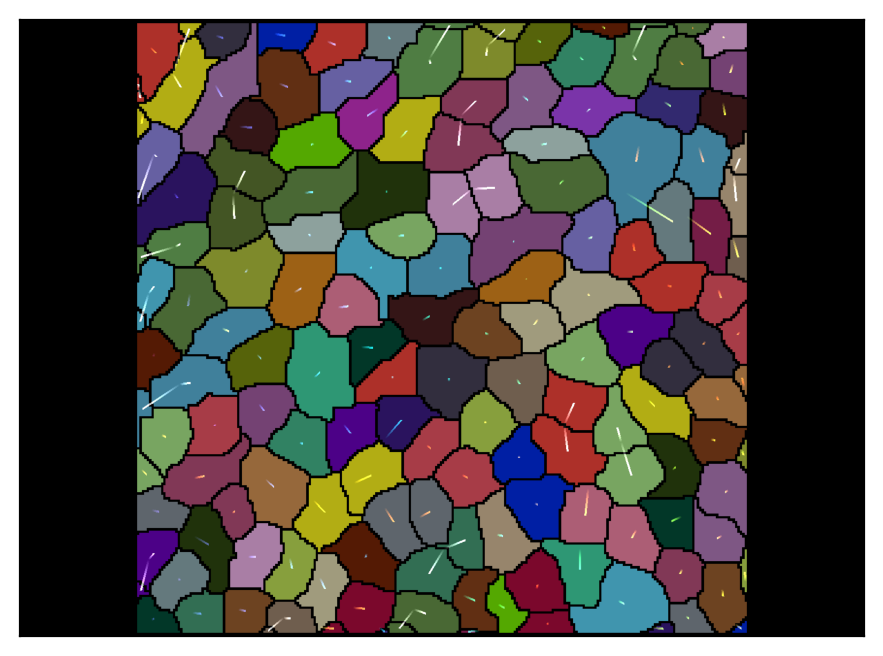

In [11]:
viewer.dims.current_step = (4, 0, 0)
plt.imshow(viewer.screenshot())
plt.xticks([])
plt.yticks([])